# 1. Linear model, predicting coin prices from BTC price 

## Imports

Import pacakges

In [59]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../')

import pystan
import stan_utility

## Data

Initialize data

In [60]:

data = pd.read_csv('/home/jonatan/projects/school/BDA_Project/data/selected/combined.csv', delimiter=",")
data.columns = ['date', 'LTC mCap', 'LTC price', 'LTC  exVol',
       'LTC fees', 'LTC  txVol', 'ETH mCap',
       'ETH price', 'ETH exVol', 'ETH fees',
       'ETH txVol', 'ETC mCap', 'ETC price',
       'ETC exVol', 'ETC fees', 'ETC txVol',
       'DASH mCap', 'DASH price', 'DASH exVol',
       'DASH fees', 'DASH txVol', 'BTC mCap',
       'BTC price', 'BTC exVol', 'BTC fees',
       'BTC txVol']
data=data[['date', 'BTC price','LTC price','DASH price','ETH price','ETC price']]
#data = (data - data.mean()) / (data.max() - data.min())
print(data.head(5))
data.drop(columns=['date'], inplace=True)

         date  BTC price  LTC price  DASH price  ETH price  ETC price
0  2016-07-24     655.41       4.06        9.36      14.30   0.752345
1  2016-07-25     661.26       4.07        9.24      12.74   0.931993
2  2016-07-26     654.23       4.04        9.15      13.82   0.604737
3  2016-07-27     651.63       3.96        8.90      12.05   2.460000
4  2016-07-28     654.49       3.97        9.15      12.98   1.560000


In [61]:
n = data.shape[0]
m = 5
x = data[['BTC price']].values.flatten()[0:n]
y1 = data[['DASH price']].values.flatten()[0:n]
y2 = data[['LTC price']].values.flatten()[0:n]
y3 = data[['ETH price']].values.flatten()[0:n]
y4 = data[['ETC price']].values.flatten()[0:n]
p = np.linspace(data[['BTC price']].min(), data[['BTC price']].max(), m)
print(p)

[  548.66   5280.445 10012.23  14744.015 19475.8  ]


## Read and display edited stan code


In [62]:
with open('lin_ex2.stan') as file:
    print(file.read())

data {
	int<lower=0> N;	// number of data points
	int<lower=0> M;	// number of prediction points
	vector[N] x;	// Coin 1
	vector[N] y;	// Coin 2
	vector[M] xpreds;	// Coin 1 hypothetical future prices
}
parameters {
	real alpha;
	real beta;
	real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
	beta ~ normal(0, 1);
	y ~ normal(mu, sigma);
}
generated quantities {
	vector[M] ypreds; // Predictions based on hypothetical future prices of coin 1
	vector[N] log_lik;
	for(i in 1:M) {
		ypreds[i] = normal_rng(alpha + beta*xpreds[i], sigma);
	}
	for (i in 1:N){
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
	}
}



## Generate model

In [63]:
model = stan_utility.compile_model('lin_ex2.stan')

Using cached StanModel


## Set model data

In [64]:
data1 = dict(N=n,M=m,x=x,y=y1,xpreds=p)
fit1 = model.sampling(data=data1, seed=74749)
samples1 = fit1.extract(permuted=True)

data2 = dict(N=n,M=m,x=x,y=y2,xpreds=p)
fit2 = model.sampling(data=data2, seed=74749)
samples2 = fit2.extract(permuted=True)

data3 = dict(N=n,M=m,x=x,y=y3,xpreds=p)
fit3 = model.sampling(data=data3, seed=74749)
samples3 = fit3.extract(permuted=True)

data4 = dict(N=n,M=m,x=x,y=y4,xpreds=p)
fit4 = model.sampling(data=data4, seed=74749)
samples4 = fit4.extract(permuted=True)

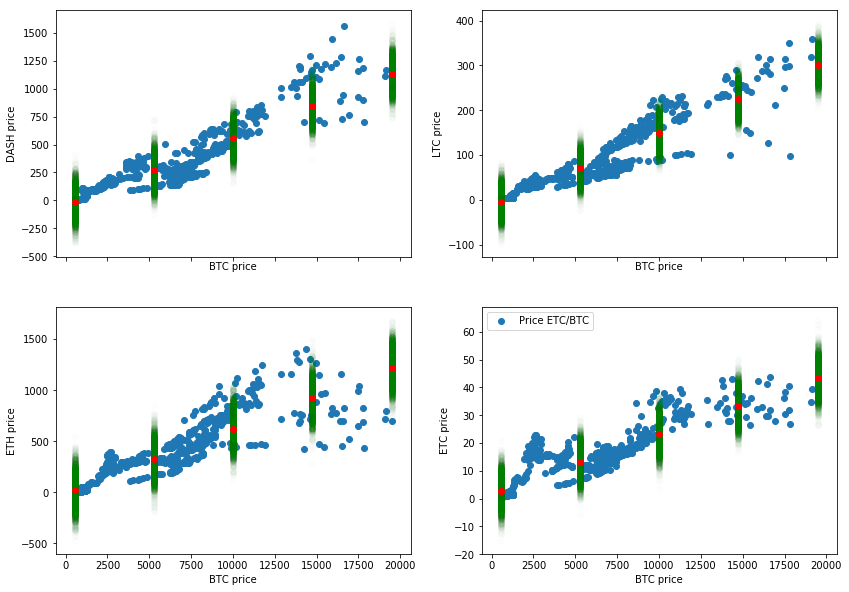

In [65]:
f, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)
preds = samples1['ypreds'].T
ax = axes[0,0]
ax.scatter(data['BTC price'], data['DASH price'], label='Price DASH/BTC')
ax.set_ylabel('DASH price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')

preds = samples2['ypreds'].T
ax = axes[0,1]
ax.scatter(data['BTC price'], data['LTC price'], label='Price LTC/BTC')
ax.set_ylabel('LTC price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')
    
preds = samples3['ypreds'].T
ax = axes[1,0]
ax.scatter(data['BTC price'], data['ETH price'], label='Price ETH/BTC')
ax.set_ylabel('ETH price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')
    
preds = samples4['ypreds'].T
ax = axes[1,1]
ax.scatter(data['BTC price'], data['ETC price'], label='Price ETC/BTC')
ax.set_ylabel('ETC price')
ax.set_xlabel('BTC price')
for i in range(m):
    ax.scatter([p[i]]*len(preds[i]),preds[i], alpha=0.01, c='g')
    ax.scatter(p[i],np.mean(preds[i]), c='r')
    
plt.legend(loc='best')
plt.show()

## Plot ypred histogram

IndexError: index 5 is out of bounds for axis 0 with size 5

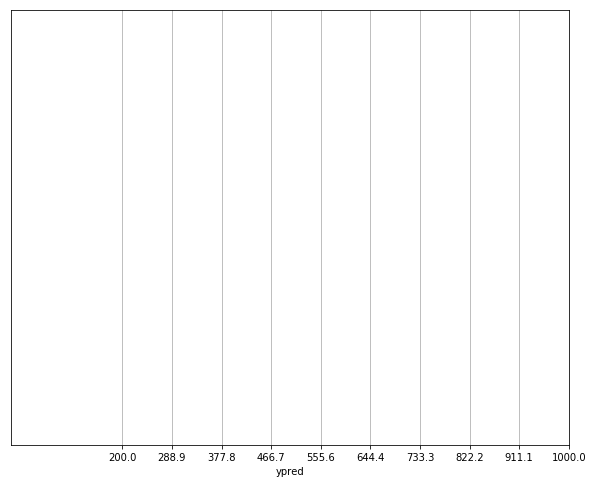

In [66]:
# plot beat histogram
fig, ax = plt.subplots(1, 1, figsize=(10,8))

# plot post pred histogram
ax.set_xlabel('ypred')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xticks(np.linspace(200, 1000, 10))
ax.grid(axis='x')
s = pd.Series(preds[5])
ax.hist(s, bins=50)
plt.show()


In [ ]:
from psis import psisloo

In [ ]:
loglik = samples1['log_lik']
loo1, loos, ks = psisloo(loglik)
print("Loo: {}".format(loo1))

In [ ]:
ks1 = [[
(ks <= 0.5).sum(),
sum([1 for k in ks if k > 0.5 and k <= 0.7]),
(ks > 0.7).sum()]]
pd.DataFrame(ks1,
columns=["k<=0.5","0.5<k<=0.7","0.7<k"])
print(ks)

In [ ]:
S = np.size(loglik, 0)
lppd = sum(np.log([1/S*sum(np.exp(col)) for col in loglik.T]))
p_loocv = lppd - loo1
print(p_loocv)